### 7.2 线性多分类的神经网络实现

<img src="https://microsoft.github.io/ai-edu/%E5%9F%BA%E7%A1%80%E6%95%99%E7%A8%8B/A2-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86/%E7%AC%AC3%E6%AD%A5%20-%20%E7%BA%BF%E6%80%A7%E5%88%86%E7%B1%BB/img/7/MultipleClassifierNN.png">  

多入多出单层神经网络
#### 输入层

输入经度 $x_1$ 和纬度 $x_2$ 两个特征：

$$
x=\begin{pmatrix}
x_1 & x_2
\end{pmatrix}
$$

#### 数据处理
首先读取数据：

In [29]:
import numpy as np
from HelperClass.NeuralNet_1_2 import *
file_name = "ch07.npz"
reader = DataReader_1_3(file_name)
reader.ReadData()
print("x: 最小值%d - 最大值%d"%(reader.XRaw.min(),reader.XRaw.max()))

x: 最小值0 - 最大值9


数据可视化：

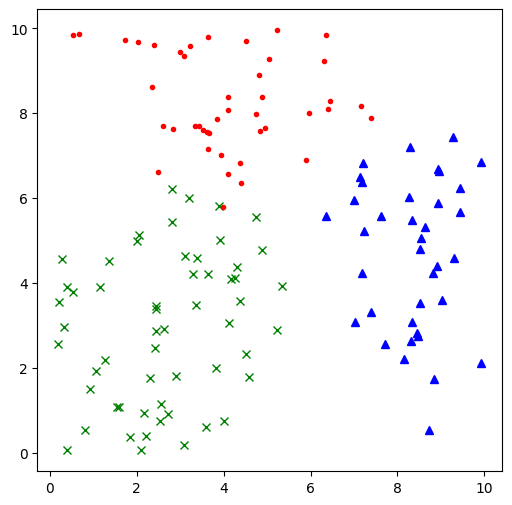

In [30]:
def ShowData(X,Y):
    plt.figure(figsize=(6,6))
    for i in range(X.shape[0]):
        if Y[i,0] == 1:
            plt.plot(X[i,0], X[i,1], '.', c='r')
        elif Y[i,0] == 2:
            plt.plot(X[i,0], X[i,1], 'x', c='g')
        elif Y[i,0] == 3:
            plt.plot(X[i,0], X[i,1], '^', c='b')
        # end if
    # end for
ShowData(reader.XRaw,reader.YRaw)

数据范围从0-9，所以我们要先给数据做归一化：

In [31]:
reader.NormalizeX()
print(reader.XTrain[0:3,:])

[[0.93278371 0.74598501]
 [0.40869526 0.40783451]
 [0.89865806 0.66969611]]


然后我们把数据转化为OneHot格式：
$$
Y = 
\begin{pmatrix}
y_1 \\\\ y_2 \\\\ \vdots \\\\ y_{140}
\end{pmatrix}=
\begin{pmatrix}
0 & 0 & 1 \\\\
0 & 1 & 0 \\\\
... & ... & ... \\\\
1 & 0 & 0
\end{pmatrix}
$$

In [32]:
num_category = 3
print("转换前：")
print(reader.YRaw[0:3])
print("转换后：")
reader.ToOneHot(num_category, base=1)
print(reader.YTrain[0:3])

转换前：
[[3.]
 [2.]
 [3.]]
转换后：
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


初始化$W,B$矩阵
$W$权重矩阵的尺寸，可以从前往后看，比如：输入层是2个特征，输出层是3个神经元，则$W$的尺寸就是 $2\times 3$。

$$
W=\begin{pmatrix}
w_{11} & w_{12} & w_{13}\\\\
w_{21} & w_{22} & w_{23} 
\end{pmatrix}
$$

$B$的尺寸是1x3，列数永远和神经元的数量一样，行数永远是1。

$$
B=\begin{pmatrix}
b_1 & b_2 & b_3 
\end{pmatrix}
$$


In [33]:
num_input = 2
num_category = 3
W = np.zeros((num_input, num_category))
B = np.zeros((1, num_category))

获取第一次迭代，一次循环的数据做演示

In [34]:
batch_size=10
batch_x, batch_y = reader.GetBatchTrainSamples(batch_size, 0)
print(batch_x)

[[0.93278371 0.74598501]
 [0.40869526 0.40783451]
 [0.89865806 0.66969611]
 [0.2678741  0.62139555]
 [0.71903616 0.6386378 ]
 [0.88502788 0.42307896]
 [0.48063809 0.47590707]
 [0.34156247 0.76146347]
 [0.52904883 0.39155129]
 [0.32204294 0.77120267]]


#### 前向计算  
矩阵运算：
$$
z = x \cdot w + b
$$
分类运算：
$$
a_j = \frac{e^{z_j}}{\sum\limits_{i=1}^m e^{z_i}}=\frac{e^{z_j}}{e^{z_1}+e^{z_2}+\dots+e^{z_m}} 
$$

In [35]:
Z = np.dot(batch_x, W) + B
print(Z)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


这个可能会发生的问题是，当x很大时，np.exp(x)很容易溢出，因为是指数运算。所以，有了下面这种改进的代码：

In [36]:
def forward(z):
    shift_z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(shift_z)
    a = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return a
batch_a = forward(Z)
print(batch_a)

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


#### 反向传播

反向传播就是一个简单的减法:
$$
\frac{\partial loss}{\partial z_i}=a_i-y_i 
$$
$$
w=\frac{1}{m} X^{\top} \cdot (Z-Y) 
$$
$$
b=\frac{1}{m}(Z-Y)
$$

In [37]:
def backwardBatch(batch_x, batch_y, batch_a):
    m = batch_x.shape[0]
    dZ = batch_a - batch_y
    print(dZ)
    dB = dZ.sum(axis=0, keepdims=True)/m
    dW = np.dot(batch_x.T, dZ)/m
    return dW, dB
dW, dB = backwardBatch(batch_x, batch_y, batch_a)
print(dW)
print(dB)

[[ 0.33333333  0.33333333 -0.66666667]
 [ 0.33333333 -0.66666667  0.33333333]
 [ 0.33333333  0.33333333 -0.66666667]
 [ 0.33333333 -0.66666667  0.33333333]
 [ 0.33333333  0.33333333 -0.66666667]
 [ 0.33333333  0.33333333 -0.66666667]
 [ 0.33333333 -0.66666667  0.33333333]
 [-0.66666667  0.33333333  0.33333333]
 [ 0.33333333 -0.66666667  0.33333333]
 [-0.66666667  0.33333333  0.33333333]]
[[ 0.12648504  0.02421996 -0.150705  ]
 [ 0.04362513  0.00722291 -0.05084804]]
[[ 0.13333333 -0.06666667 -0.06666667]]


#### 更新$w,b$的值
设置学习率为0.1，更新值

In [38]:
eta = 0.1
W = W - eta * dW
B = B - eta * dB
print(W)
print(B)

[[-0.0126485  -0.002422    0.0150705 ]
 [-0.00436251 -0.00072229  0.0050848 ]]
[[-0.01333333  0.00666667  0.00666667]]


#### 计算损失函数值
损失函数不再是均方差和二分类交叉熵了，而是交叉熵函数对于多分类的形式，并且添加条件分支来判断只在网络类型为多分类时调用此损失函数。  
计算单样本时，m是分类数：
$$
loss(w,b)=-\sum_{i=1}^m y_i \ln a_i \tag{3}
$$

计算多样本时，m是分类数，n是样本数：
$$J(w,b) =- \sum_{j=1}^n \sum_{i=1}^m y_{ji} \log a_{ji} \tag{4}$$

重新计算所有的$A$：

In [39]:
X,Y = reader.GetWholeTrainSamples()
m = X.shape[0]
Z = np.dot(X, W) + B
A = forward(Z)



计算$LOSS$:

In [40]:
def CheckLoss(A, Y):
        m = Y.shape[0]
        p1 = np.log(A)
        p2 =  np.multiply(Y, p1)
        LOSS = np.sum(-p2)
        loss = LOSS / m
        return loss
loss = CheckLoss(A, Y)
print(loss)

1.0974039847640213


#### 正式训练

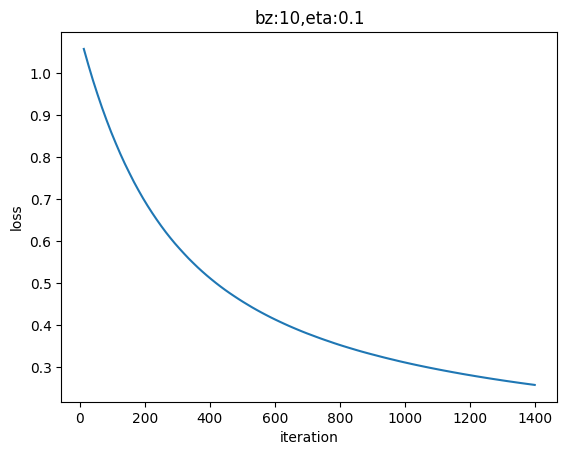

W= [[-1.73952402 -3.23834453  4.97786854]
 [ 4.75562922 -3.17976625 -1.57586297]]
B= [[-1.70699286  3.5300115  -1.82301864]]


In [41]:
params = HyperParameters_1_1(num_input, num_category, eta=0.1, max_epoch=100, batch_size=10, eps=1e-3, net_type=NetType.MultipleClassifier)
net = NeuralNet_1_2(params)
net.train(reader, checkpoint=1)

#### 测试值

In [42]:
def inference(net, reader):
    xt_raw = np.array([5,1,7,6,5,6,2,7]).reshape(4,2)
    print("测试数据：\n",xt_raw)
    # 测试数据做归一化
    xt = reader.NormalizePredicateData(xt_raw)
    # 做一遍前向计算
    output = net.inference(xt)
    r = np.argmax(output, axis=1)+1
    print("输出=\n", output)
    print("r=", r)

inference(net, reader)

测试数据：
 [[5 1]
 [7 6]
 [5 6]
 [2 7]]
输出=
 [[0.01758115 0.74560647 0.23681237]
 [0.26715841 0.15060428 0.58223732]
 [0.43192543 0.33129802 0.23677655]
 [0.63208089 0.34487737 0.02304174]]
r= [2 3 1 1]


数据可视化：

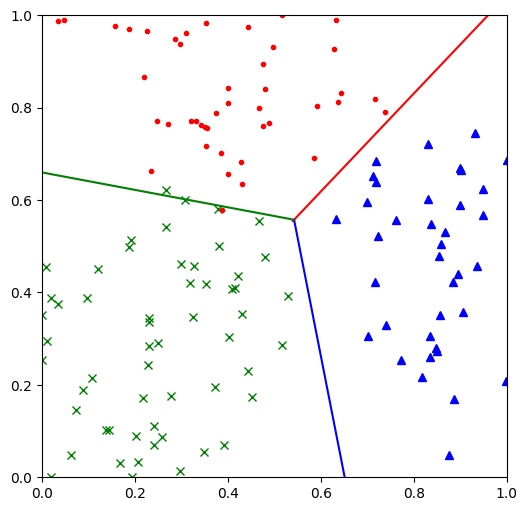

In [63]:
reader.NormalizeX()
ShowData(reader.XTrain,reader.YRaw)
b13 = (net.B[0,0] - net.B[0,2])/(net.W[1,2] - net.W[1,0])
w13 = (net.W[0,0] - net.W[0,2])/(net.W[1,2] - net.W[1,0])
b23 = (net.B[0,2] - net.B[0,1])/(net.W[1,1] - net.W[1,2])
w23 = (net.W[0,2] - net.W[0,1])/(net.W[1,1] - net.W[1,2])
b12 = (net.B[0,1] - net.B[0,0])/(net.W[1,0] - net.W[1,1])
w12 = (net.W[0,1] - net.W[0,0])/(net.W[1,0] - net.W[1,1])
plt.xlim(0,1)
plt.ylim(0,1)
x = np.linspace(0.54,1)
y = w13 * x + b13
p13, = plt.plot(x,y,c='r')
x = np.linspace(0.543,1)
y = w23 * x + b23
p23, = plt.plot(x,y,c='b')
x = np.linspace(0,0.54)
y = w12 * x + b12
p12, = plt.plot(x,y,c='g')